In [1]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import sys
import os
import math

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display

# Finally, pycroscopy itself
import pycroscopy as px

from os.path import join as pjoin

# set up notebook to show plots within the notebook
% matplotlib inline

import glob

#import moviepy.video.io.ImageSequenceClip
#try:
#    output = subprocess.check_output(['ffmpeg', '-version'])
#    version = output.split(b'\n')[0].split()[2]
#    print('Found: ffmpeg v{}'.format(version.decode('utf-8')))
#    ffmpeg_installed = True
#except:
 #   ffmpeg_installed = False

In [ ]:
%%file custom.mplstyle

axes.linewidth: 1.5
xtick.major.size: 6
xtick.minor.size: 2
xtick.major.width: 1.5
xtick.minor.width: 1.5
ytick.major.size: 6
ytick.minor.size: 2
ytick.major.width: 1.5
ytick.minor.width: 1.5
axes.labelweight: bold
axes.labelpad: 1
axes.labelsize: 12
xtick.major.pad: 1
ytick.major.pad: 1
xtick.labelsize: 12
ytick.labelsize: 12
xtick.top: True
ytick.right: True
xtick.direction: in
ytick.direction: in
image.interpolation: nearest
    
# Loads the custom style
plt.style.use('./custom.mplstyle')

In [2]:
plt.style.use('./custom.mplstyle')

C:\Users\Josh_\Anaconda3\lib\site-packages\matplotlib\__init__.py:955: UserWarning: Illegal line #25
	"plt.style.use('./custom.mplstyle')"
	in file "./custom.mplstyle"
  warnings.warn('Illegal %s' % error_details)


In [3]:
 input_file_path ='D:/PZT001_BEPs_0003.h5' #px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                         #filter='Translated file (*.h5);; \\ Parameters for raw BE data (*.txt *.mat *xls *.xlsx)')

(data_dir, data_name) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
print('Working on:\n' + h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]

File is already Pycroscopy ready.
Working on:
D:/PZT001_BEPs_0003.h5


In [4]:
h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores)
    h5_sho_fit = sho_fitter.do_fit(processors=max_cores)
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    try:
        h5_sho_fit = h5_sho_group[-1]['Fit']
    except KeyError:
        print('Previously computed guess found. Now computing fit')
        h5_sho_fit = sho_fitter.do_fit(processors=max_cores, h5_guess=h5_sho_guess)

Taking previous SHO results already present in file


In [ ]:
# Specify output file path
#output_file_path = './'

# If HV amplifier was used set high_voltage_amplf to 10, else to 1
#high_voltage_amplf = 10


In [5]:
(Nd_mat, success) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit)
print('Reshape Success = ' + str(success))
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

# phase_offset = 0;

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset

Reshape Success = True
Nd_mat shape =  (80, 80, 128, 2, 3)
Phase offset [rad] =  0.342565


In [ ]:
#Nd_mat["Phase [rad]"].shape[2]

In [6]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from scipy import io
import numpy as np
import pycroscopy as px
import matplotlib.pyplot as plt
from os.path import join as pjoin
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
import os
from os.path import join as pjoin
from keras.regularizers import l1
import sys


% matplotlib inline

Using TensorFlow backend.


In [ ]:
#len(qf_on.reshape(-1))

In [7]:
def norm(indat):
    indat-=np.mean(indat)
    indat/=np.std(indat)
    return indat

In [8]:
amp_off = np.atleast_3d(Nd_mat["Amplitude [V]"][:,:,:,1,2].reshape(-1,128))
phase_off = np.atleast_3d(Nd_mat["Phase [rad]"][:,:,:,1,2].reshape(-1,128))
freq_off = np.atleast_3d(Nd_mat["Frequency [Hz]"][:,:,:,1,2].reshape(-1,128))
qf_off = np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,1,2].reshape(-1,128))

amp_on = np.atleast_3d(Nd_mat["Amplitude [V]"][:,:,:,0,2].reshape(-1,128))
phase_on = np.atleast_3d(Nd_mat["Phase [rad]"][:,:,:,0,2].reshape(-1,128))
freq_on = np.atleast_3d(Nd_mat["Frequency [Hz]"][:,:,:,0,2].reshape(-1,128))
qf_on= np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,0,2].reshape(-1,128))

In [9]:
amp_off = np.atleast_3d(norm(amp_off))
phase_off = np.atleast_3d(norm(phase_off))
freq_off = np.atleast_3d(norm(freq_off))
qf_off = np.atleast_3d(norm(qf_off))

amp_on = np.atleast_3d(norm(amp_on))
phase_on = np.atleast_3d(norm(phase_on))
freq_on = np.atleast_3d(norm(freq_on))
qf_on= np.atleast_3d(norm(qf_on))

In [10]:
for i in range(len(qf_on.reshape(-1))):
    if qf_on.reshape(-1)[i] > 900:
        qf_on.reshape(-1)[i] = np.mean(qf_on)
        
for i in range(len(qf_off.reshape(-1))):
    if qf_off.reshape(-1)[i] > 900:
        qf_off.reshape(-1)[i] = np.mean(qf_off)

In [ ]:
#np.std((Nd_mat["Amplitude [V]"][:,:,:,1,2].reshape(-1)))

In [ ]:
fig = plt.figure(figsize=(24, 18))
ax_amp_off = plt.subplot2grid((2, 4), (0, 0), colspan=1, rowspan=1)
ax_amp_on = plt.subplot2grid((2, 4), (0, 1), colspan=1, rowspan=1)
ax_phase_off = plt.subplot2grid((2, 4), (0, 2), colspan=1, rowspan=1)
ax_phase_on = plt.subplot2grid((2, 4), (0, 3), colspan=1, rowspan=1)
ax_freq_off = plt.subplot2grid((2, 4), (1, 0), colspan=1, rowspan=1)
ax_freq_on = plt.subplot2grid((2, 4), (1, 1), colspan=1, rowspan=1)
ax_qf_off = plt.subplot2grid((2, 4), (1, 2), colspan=1, rowspan=1)
ax_qf_on = plt.subplot2grid((2, 4), (1, 3), colspan=1, rowspan=1)


ax_amp_off.hist(amp_off.reshape(-1),100)
ax_amp_on.hist(amp_on.reshape(-1),100)
ax_phase_off.hist(phase_off.reshape(-1),100)
ax_phase_on.hist(phase_on.reshape(-1),100)
ax_freq_off.hist(freq_off.reshape(-1),100) 
ax_freq_on.hist(freq_on.reshape(-1),100)
ax_qf_off.hist(qf_off.reshape(-1),100)
ax_qf_on.hist(qf_on.reshape(-1),100)
    
    
    
    
#(amp_on.reshape(-1),100)


In [11]:
## PCA of imput data to remove noise
import sklearn

In [ ]:
am = amp_off[:,:,0]
am.shape

In [12]:
# set the number of principle components
PC_number = 70
pca = sklearn.decomposition.PCA(n_components=PC_number)
pca_amp = pca.fit(amp_off[:,:,0])
pca_recon_amp = pca.inverse_transform(pca.transform(amp_off[:,:,0]))

In [13]:
pca_input_amp_off = np.atleast_3d(pca_recon_amp[:,::2])
pca_input_amp_off.shape

(6400, 64, 1)

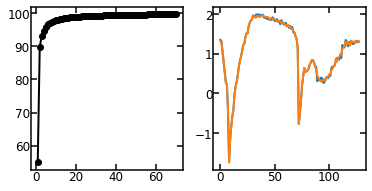

In [14]:
fig, axes = plt.subplots(1,2, figsize=(6,3))

axes[0].plot(np.linspace(1, PC_number, PC_number),
             np.cumsum(pca_amp.explained_variance_ratio_) * 100,
             '-ok')
t = np.random.randint(0,3600)
axes[1].plot(amp_off[t,:])
axes[1].plot(pca_recon_amp[t,:])


In [15]:
def make_folder(folder_name, root='D:/'):

    folder = pjoin(root, '{}'.format(folder_name))
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [ ]:
def network1(inp):
    out = Bidirectional(LSTM(128, return_sequences=False))(inp)
    en_out_a_off = Dense(16, activation='relu')(out)
    x = RepeatVector(64)(en_out_a_off)   
    #x = TimeDistributed(Dense(1, activation='linear'))(en_out_a_off)
    x = Bidirectional(LSTM(128, activation= "sigmoid", return_sequences=True))(x)
    x = TimeDistributed(Dense(1, activation='linear'))(x)
    return x

In [ ]:
def network2(inp):
    out = Bidirectional(LSTM(128, return_sequences=True))(inp)
    en_out_a_off = Dense(16, activation='relu')(out)
    #x = RepeatVector(64)(en_out_a_off)   
    #x = TimeDistributed(Dense(1, activation='linear'))(en_out_a_off)
    x = Bidirectional(LSTM(128, activation= "sigmoid", return_sequences=True))(en_out_a_off)
    x = TimeDistributed(Dense(1, activation='linear'))(x)
    return x

In [ ]:
def network3(inp):
    out = Bidirectional(LSTM(128,activation = "sigmoid", return_sequences=True))(inp)
    x = TimeDistributed(Dense(1, activation="linear"))(out)
    return x

In [16]:
def encode_layer(size, numbernodes,x):
    for i in range(size-1):
        x = Bidirectional(LSTM(numbernodes, return_sequences=True))(x)
    out = Bidirectional(LSTM(numbernodes, return_sequences=False))(x)
    return out

In [26]:
def decode_layer(size, numbernodes,x):
    x = RepeatVector(64)(x)
    for i in range(size):
        x = Bidirectional(LSTM(numbernodes, return_sequences=True))(x)
    x = TimeDistributed(Dense(1, activation='linear'))(x)
    return x

In [18]:
mods = keras.models.load_model("D:/Layerwise/amp_only4/weights.4419-0.02.hdf5")
mods_2 = keras.models.load_model("D:/Layerwise/amp_second/weights.5000-0.02.hdf5")
mods_3 = keras.models.load_model("D:/Layerwise/amp_third/weights.5000-0.02.hdf5")
mods_4 = keras.models.load_model("D:/Layerwise/amp_encode/weights.5000-0.01.hdf5")
mods_5 = keras.models.load_model("D:/Layerwise/amp_decode_2/weights.5000-0.01.hdf5")

In [ ]:
mods.summary()

In [ ]:
mods_2.summary()

In [21]:
mods_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4112      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 16)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64, 256)           148480    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 64, 1)             257       
Total params: 547,089
Trainable params: 547,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mods_4.summary()

In [22]:
mods_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 256)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64, 256)           394240    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 64, 1)             257       
Total params: 394,497
Trainable params: 394,497
Non-trainable params: 0
_________________________________________________________________



input_off_freq=Input(shape=(Nd_mat["Phase [rad]"].shape[2]//2,1))
x = network2(input_off_freq)
gen = Model(inputs=[input_off_freq], 
              outputs=x)

gen.compile(optimizer=Adam(3e-5),loss='mse')#

lbs_list = mods.get_weights()
gen.set_weights(lbs_list)

def get_ith_layer_output(model, X, i, mode='test'):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
    return layer_output

one = get_ith_layer_output(gen,pca_input_amp_off,1)

input_layer_1=Input(shape=(one.shape[1:]))
x = network2(input_layer_1)
gen_2 = Model(inputs=[input_layer_1], 
              outputs=x)

gen_2.compile(optimizer=Adam(3e-5),loss='mse')#

lbs_2 = mods_2.get_weights()
gen_2.set_weights(lbs_2)

two = get_ith_layer_output(gen_2,one,1)

input_layer_1=Input(shape=(two.shape[1:]))
x = network1(input_layer_1)
model = Model(inputs=[input_layer_1], 
              outputs=x)
model.compile(optimizer=Adam(3e-5),loss='mse')#

lbs_3 = mods_3.get_weights()
model.set_weights(lbs_3)

# get the ith layer
three = get_ith_layer_output(model, two, 4)

three.shape[1:]

# create final layer with ith layer input

input_decode=Input(shape=(three.shape[1:]))
x = network3(input_decode)
decode = Model(inputs=[input_decode],
              outputs=x)
decode.compile(optimizer=Adam(3e-5),loss='mse')

lbs_4 = mods_4.get_weights()
decode.set_weights(lbs_4)

four = get_ith_layer_output(decode, three, 1)


input_decode=Input(shape=(four.shape[1:]))
x = network3(input_decode)
decode_2 = Model(inputs=[input_decode],
              outputs=x)
decode_2.compile(optimizer=Adam(3e-5),loss='mse')

In [20]:
one_channel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 256)           133120    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 256)           394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 16)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 256)           148480    
__________

In [27]:
input_off_amp =Input(shape=(Nd_mat["Phase [rad]"].shape[2]//2,1))

amp = encode_layer(3,128, input_off_amp)
amp = Dense(16, activation='relu',activity_regularizer=l1(10e-4))(amp)

de_amp = decode_layer(3,128,amp)

one_channel= Model(inputs=[input_off_amp],
                  outputs=de_amp)
one_channel.compile(optimizer=Adam(3e-5), loss="mse")

In [28]:
first = mods.layers[1].get_weights()
second = mods_2.layers[1].get_weights()
third = mods_3.layers[1].get_weights()
dense = mods_3.layers[2].get_weights()
repeat = mods_3.layers[3].get_weights()
fourth = mods_3.layers[4].get_weights()
fith = mods_4.layers[1].get_weights()
sixth = mods_5.layers[1].get_weights()
time = mods_5.layers[2].get_weights()

In [29]:
one_channel.layers[1].set_weights(first)
one_channel.layers[2].set_weights(second)
one_channel.layers[3].set_weights(third)
one_channel.layers[4].set_weights(dense)
one_channel.layers[5].set_weights(repeat)
one_channel.layers[6].set_weights(fourth)
one_channel.layers[7].set_weights(fith)
one_channel.layers[8].set_weights(sixth)
one_channel.layers[9].set_weights(time)

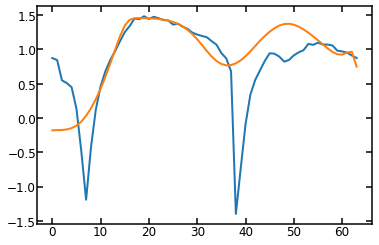

In [51]:
i = np.random.randint(0, 3600)
output = one_channel.predict(np.atleast_3d(pca_input_amp_off[i,:,0])).squeeze()

plt.plot(pca_input_amp_off[i])
plt.plot(output)

In [44]:
Path = 'amp_pretrain'
make_folder(Path)
tbCallBack = keras.callbacks.TensorBoard(
    log_dir='./' + Path, histogram_freq=0, write_graph=True, write_images=True)
filepath = './' + Path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_best_only=False,
                                             save_weights_only=False, mode='min', period=1)
#from keras.utils import multi_gpu_model

# Replicates `model` on 2 GPUs.
# This assumes that your machine has 2 available GPUs.
#parallel_model = multi_gpu_model(model, gpus=2)
#parallel_model.compile(optimizer=Adam(3e-5),loss='mse')

one_channel.fit([pca_input_amp_off], 
            [pca_input_amp_off],
          validation_data=([pca_input_amp_off], 
          [pca_input_amp_off]),
          epochs=5000,batch_size=1024, callbacks=[tbCallBack, checkpoint])

Train on 6400 samples, validate on 6400 samples


KeyboardInterrupt: 